In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

---

## Century21

In [92]:
file_path = 'data/century21Paris.csv'
data = pd.read_csv(file_path)

#### Visualisation

In [93]:
df = data.copy()
df.shape
df.dtypes.value_counts() # Différentes types de données des colonnes

object     2
int64      2
float64    1
Name: count, dtype: int64

In [94]:
df.head()

,Ville,Arrondissement,Surface (m2),Pièce(s),Prix (€)
0,PARIS,75008,9.00,1,536
1,PARIS,75019,49.70,2,1446
2,PARIS,75016,42.87,1,1480
3,PARIS,75013,84.30,4,2550
4,PARIS,75015,45.28,2,1650


In [95]:
df.columns

Index(['Ville', 'Arrondissement', 'Surface (m2)', 'Pièce(s)', 'Prix (€)'], dtype='object')

#### Statistiques et Filtres

In [96]:
# Counting

df['Ville'].value_counts()

Ville
PARIS    71
Name: count, dtype: int64

### Analyse de Fond :
- **Visualisation de la target** :
- **Signification des variables** :
- **Relation Variables / Target** :

In [97]:
df['Prix (€)'] = df['Prix (€)'].astype(float)
numerical_df = df.select_dtypes(include=['int64', 'float64'])

numerical_df.describe(include='all')

,Arrondissement,Surface (m2),Pièce(s),Prix (€)
count,71.000000,71.000000,71.000000,71.000000
mean,75022.295775,57.289718,2.492958,2275.295775
std,29.003150,48.430062,1.672238,2993.795677
min,75003.000000,9.000000,1.000000,385.000000
25%,75011.000000,33.110000,1.000000,1195.000000
50%,75015.000000,46.810000,2.000000,1685.000000
75%,75018.000000,61.850000,3.000000,2218.500000
max,75116.000000,316.010000,12.000000,21500.000000


### Analyse dataset

In [98]:
# Standardize the data
scaler = StandardScaler()
scaler.fit(numerical_df)
data_scaled = scaler.transform(numerical_df)
dataStd = pd.DataFrame(data_scaled, columns=numerical_df.columns)

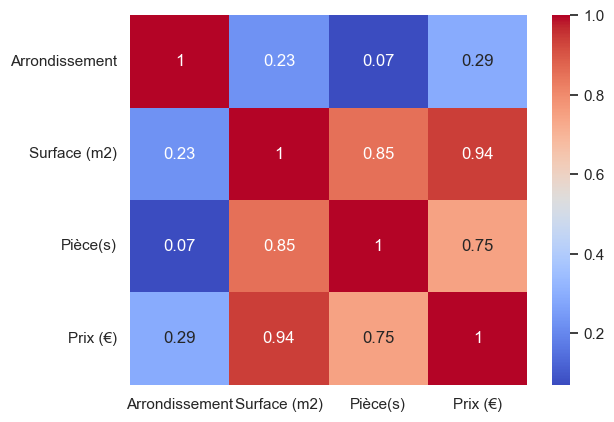

In [99]:
sns.heatmap(dataStd.corr(), annot=True, cmap='coolwarm');

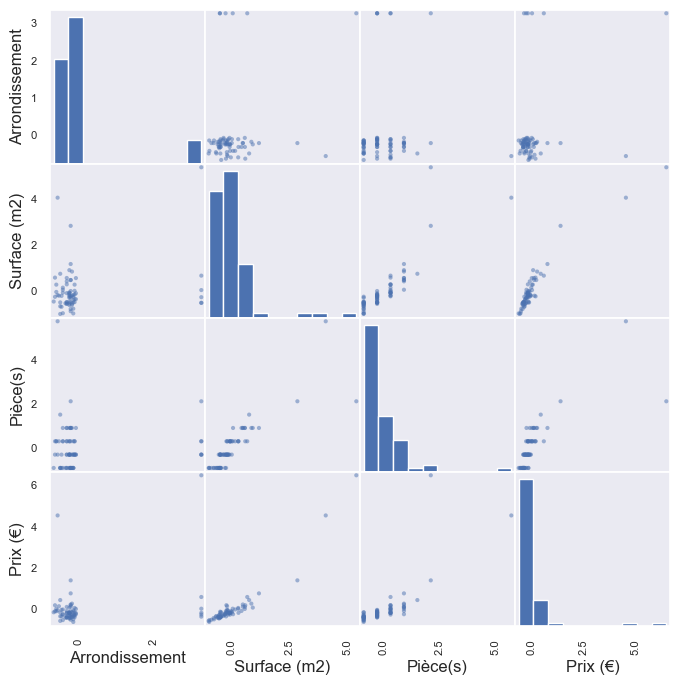

In [100]:
pd.plotting.scatter_matrix(dataStd, figsize=(8, 8));

On note que le nombre de pièces a une distribution concentrée avec des valeurs extrêmes, tandis que les prix et les surfaces présentent une large dispersion avec de nombreux points éloignés de la concentration principale, indiquant des valeurs extrêmes ou aberrantes. Le graphique inférieur droit identifie spécifiquement les valeurs aberrantes, isolant visiblement les données qui s'écartent de la tendance générale.

De plus on remarque une correlation entre la surface et prix car les points montrent globalement une tendance linéaire où y = x

### Outlier detection

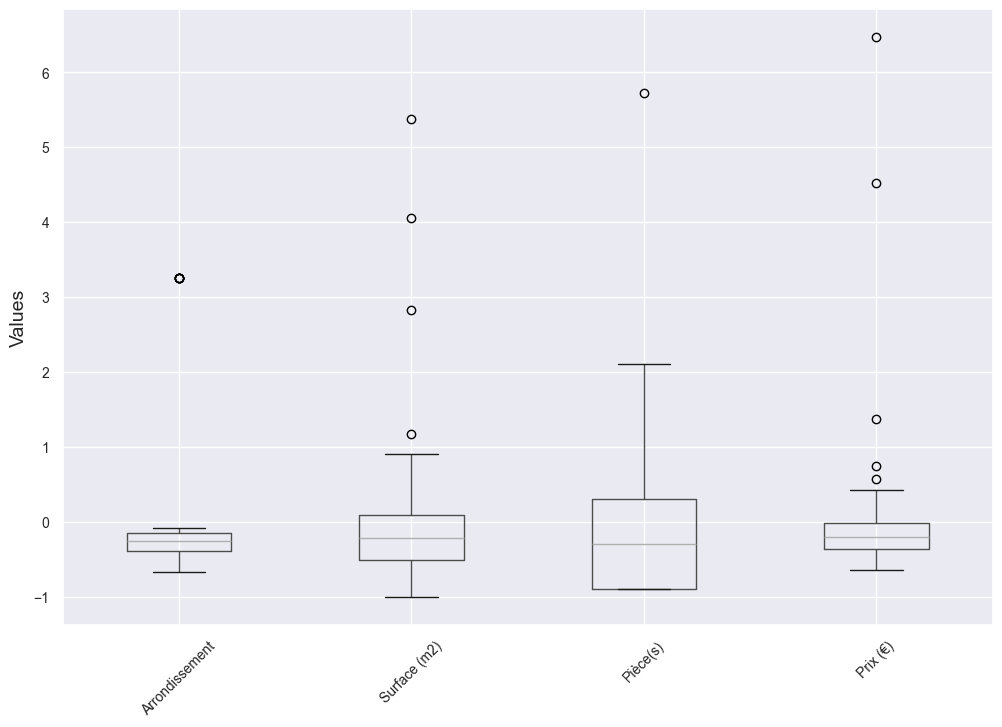

In [101]:
plt.figure(figsize=(12, 8))

dataStd.boxplot(rot=45, fontsize=10)
plt.ylabel("Values", fontsize=14)
plt.show()

Les variables "Arrondissement" et "Pièces" ont des plages de valeurs relativement étroites et moins de valeurs aberrantes, ce qui suggère une distribution plus serrée des données. En revanche, "Prix (€)", "Prix mensuel (€)" et "Surface (m²)" montrent une plus grande variabilité avec de nombreuses valeurs aberrantes, indiquant des écarts importants dans les données. La médiane semble relativement basse pour les catégories "Prix" et "Surface", ce qui pourrait indiquer une asymétrie dans la distribution des prix et des tailles des surfaces.

In [102]:
outliers_count = 0

for col in dataStd.columns:
    col_values = dataStd[col]
    z_scores = (col_values - col_values.mean()) / col_values.std()
    outliers_count += (abs(z_scores) > 3).sum()

# Display the count of lines to be removed
print(f"Total lines to be removed: {outliers_count}")

Total lines to be removed: 11


In [103]:
# Initialize the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.05, random_state=42)

isolation_forest.fit(dataStd)
outlier_predictions = isolation_forest.predict(dataStd)

outliers_count = (outlier_predictions == -1).sum()

print(f"Total outliers identified: {outliers_count}")

Total outliers identified: 4


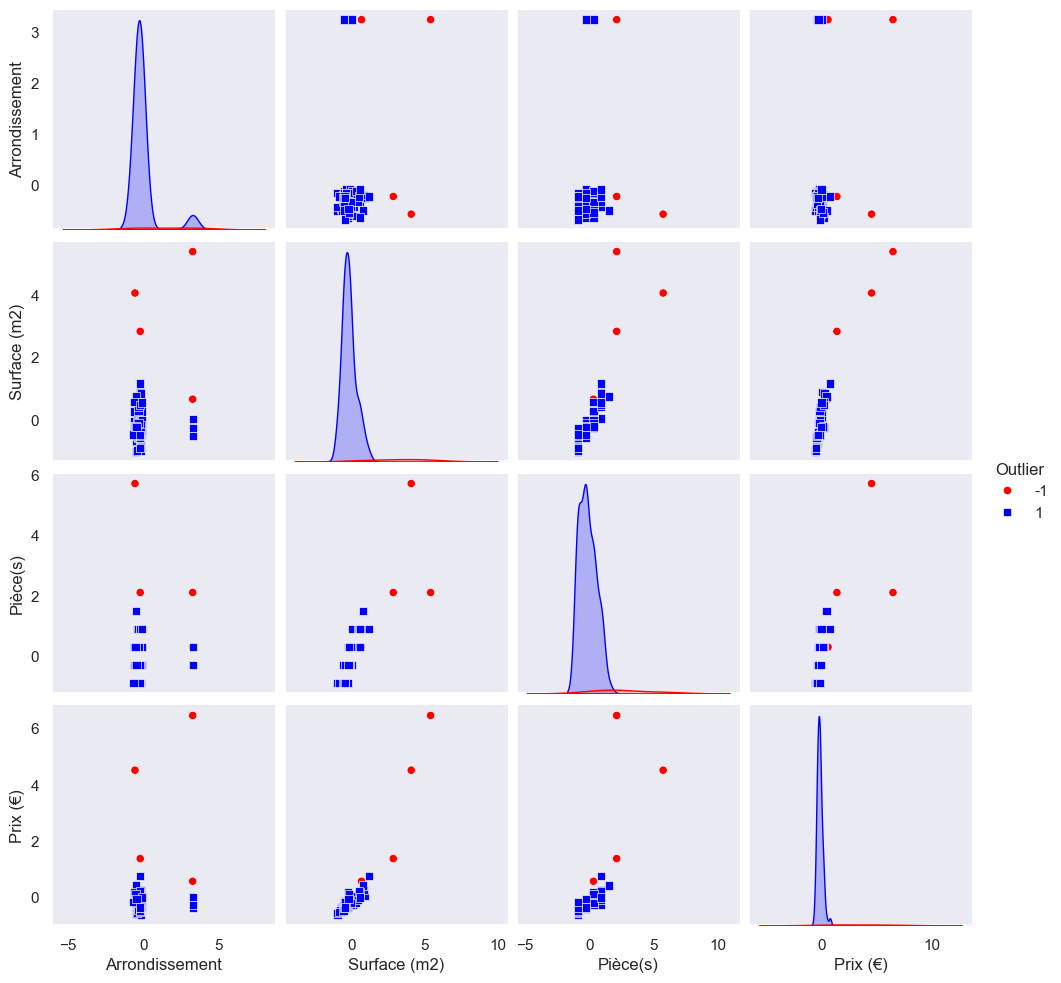

In [104]:
# Add a new column 'Outlier' to the DataFrame indicating whether each row is an outlier or not
dataStdCopy = dataStd.copy()
dataStdCopy['Outlier'] = outlier_predictions

# Create pair plots using seaborn
sns.set(style="dark")
sns.pairplot(dataStdCopy, hue='Outlier', palette={-1: 'red', 1: 'blue'}, markers=['o', 's'], height=2.5)
plt.show()

 Les points bleus représentent les données standard, tandis que les points rouges signalent des valeurs aberrantes. Il y a des distributions asymétriques pour le prix et la surface, comme en témoignent les longues queues sur les histogrammes de densité correspondants. Les nuages de points révèlent des corrélations possibles, par exemple entre le prix et la surface ou le prix mensuel et la surface. Les valeurs aberrantes sont particulièrement notables dans la relation entre le nombre de pièces et les autres variables, ce qui suggère des anomalies spécifiques, comme des appartements exceptionnellement grands ou chers par rapport au reste de l'échantillon.

### Réduction de dimension

In [105]:
pca = PCA()
pca.fit(dataStd)
pca_data = pca.transform(dataStd)
n = dataStd.shape[0] # nb of individuals
p = dataStd.shape[1] # nb of variables
print(n, "samples")
print(p, "variables")

71 samples
4 variables


In [106]:
explained_variances = pca.explained_variance_
simple_var_proportions = explained_variances / explained_variances.sum()
cumulative_var_proportions = np.cumsum(simple_var_proportions)
labels = [f'PC{i}' for i in range(1, len(explained_variances) + 1)]

summary_table = pd.DataFrame({
    'Explained Variance': explained_variances,
    'Simple Variance Proportion': simple_var_proportions,
    'Cumulative Variance Proportion': cumulative_var_proportions
}, index=labels)

summary_table

,Explained Variance,Simple Variance Proportion,Cumulative Variance Proportion
PC1,2.799329,0.689976,0.689976
PC2,0.979681,0.241471,0.931446
PC3,0.235890,0.058142,0.989588
PC4,0.042243,0.010412,1.000000


<BarContainer object of 4 artists>

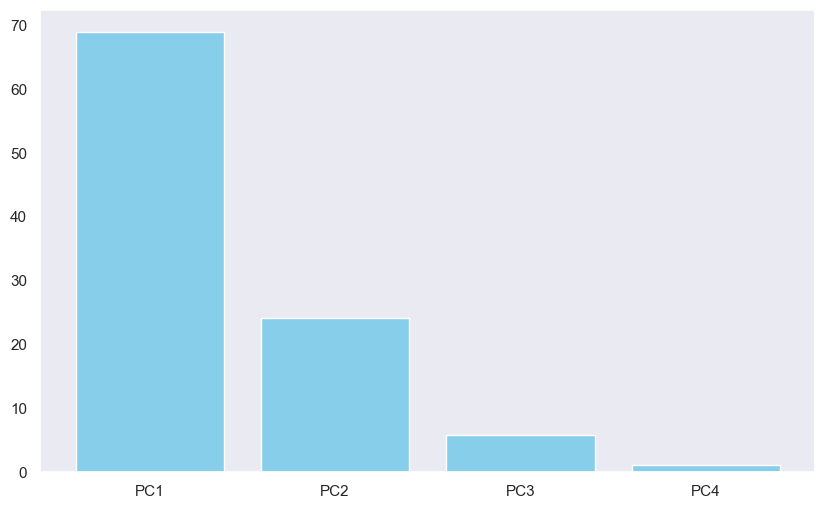

In [107]:
# Convert simple variance proportions to percentages
simple_var_proportions_percent = simple_var_proportions * 100

plt.figure(figsize=(10, 6))
plt.bar(summary_table.index, simple_var_proportions_percent, color='skyblue')

In [108]:
singular_values = np.sqrt(pca.explained_variance_)
corvar_data = {'id': dataStd.columns}
for k in range(p):
    corvar_data[labels[k]] = pca.components_[k,:] * singular_values[k]

coordvar = pd.DataFrame(corvar_data)
coordvar

,id,PC1,PC2,PC3,PC4
0,Arrondissement,0.319862,0.949670,-0.100490,0.001643
1,Surface (m2),0.986556,-0.082255,0.092097,0.160451
2,Pièce(s),0.896906,-0.266015,-0.369414,-0.051128
3,Prix (€),0.958793,0.016664,0.284330,-0.117818


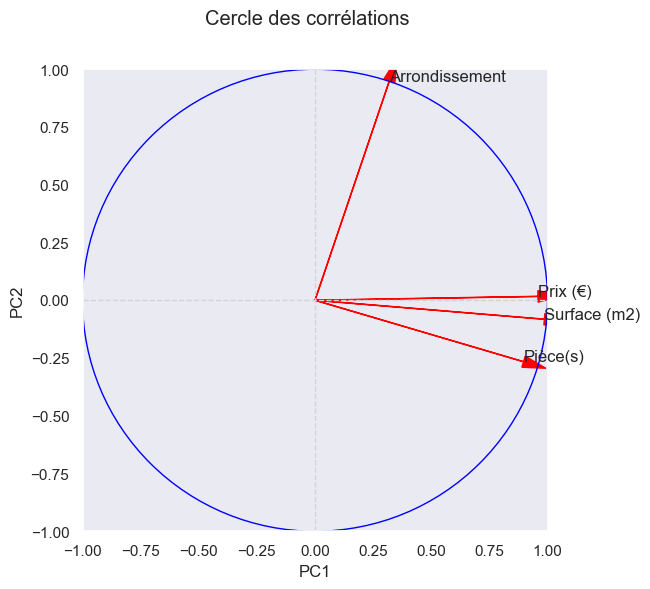

In [109]:
fig, axes = plt.subplots(figsize=(6, 6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)

# Ajout des titres
axes.set_xlabel('PC1')
axes.set_ylabel('PC2')

# Ajout des axes
axes.axvline(x=0, color='lightgray', linestyle='--', linewidth=1)
axes.axhline(y=0, color='lightgray', linestyle='--', linewidth=1)

# Ajout des noms des variables et des flèches
for j in range(p):
    axes.arrow(0, 0, coordvar[labels[0]][j], coordvar[labels[1]][j], head_width=0.05, head_length=0.1, fc='red', ec='red')
    axes.text(coordvar[labels[0]][j], coordvar[labels[1]][j], coordvar["id"][j])

# Ajout du cercle
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
axes.add_artist(circle)

plt.show()

Le prix d'achat et la surface habitable sont étroitement liés à PC1, indiquant que généralement, une plus grande surface implique un prix plus élevé pour les biens immobiliers. Le loyer mensuel est aussi lié au PC1, mais dans une moindre mesure, suggérant que d’autres éléments influencent également le loyer au-delà de la surface de la propriété. D'autre part, l'arrondissement montre une corrélation plus marquée avec la deuxième composante principale (PC2), ce qui suggère qu'il affecte les valeurs immobilières d'une manière qui ne se résume pas uniquement à une augmentation de la surface ou du prix. Le nombre de pièces a une influence sur les deux composantes, bien que moins prépondérante que la surface ou le prix. Toutes ces variables sont relativement proches du cercle de corrélation, ce qui indique qu'elles sont assez bien représentées par ces deux composantes principales, bien qu'une certaine quantité d'informations soit perdue, comme le montre le fait qu'aucune variable n'est parfaitement alignée sur le cercle.

(71, 4)

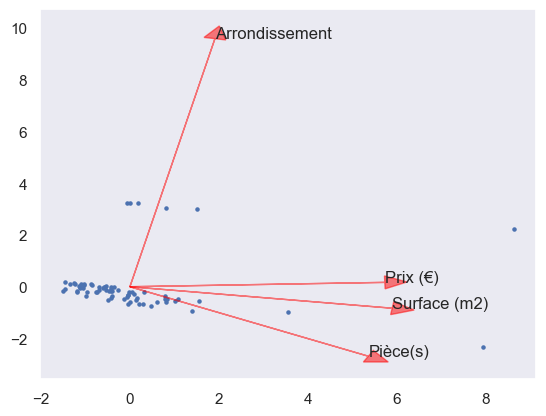

In [110]:
plt.scatter(pca_data[:,0],pca_data[:,1],s=5)
for i in range(pca.components_.shape[1]):
    plt.arrow(0,0,pca.components_[0,i]*10,pca.components_[1,i]*10,alpha=0.5, color='red', head_width=0.5, head_length=0.5)
    plt.text(pca.components_[0,i]*10,pca.components_[1,i]*10,dataStd.columns[i])

pca_data.shape

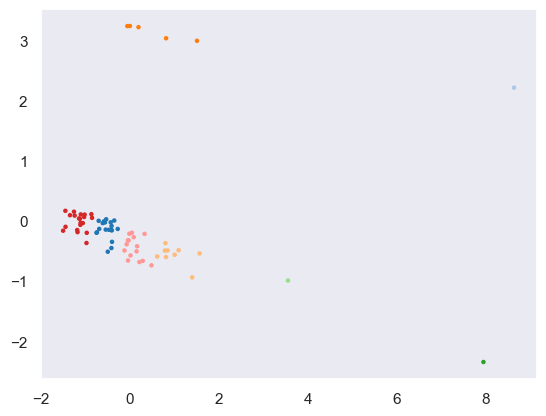

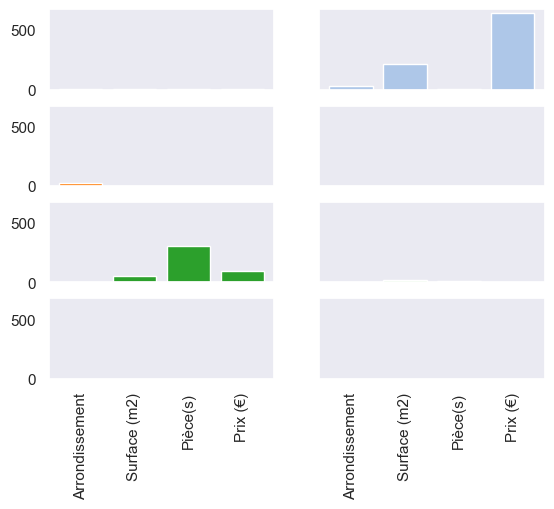

In [111]:
from sklearn.cluster import KMeans

km = KMeans(n_clusters=5)
km.n_clusters = 8
pred = km.fit_predict(pca_data)
plt.scatter(pca_data[:,0],pca_data[:,1],color = [plt.cm.tab20.colors[pred[i]] for i in range(len(pca_data))],s=5)
real_centers = np.exp(pca.inverse_transform(km.cluster_centers_))
fig, axs = plt.subplots(km.n_clusters//2, 2, sharey=True,sharex=True)
for i,k in enumerate(real_centers):
    axs.flatten()[i].bar(range(len(k)),k,color=plt.cm.tab20.colors[i])
    axs.flatten()[i].set_xticks(range(len(k)))
    axs.flatten()[i].set_xticklabels(dataStd.columns,rotation="vertical")

tab20 = plt.get_cmap('tab20')

/usr/local/anaconda3/envs/venv_ml/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:383: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/usr/local/anaconda3/envs/venv_ml/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/var/folders/jl/05xr553n44v3_nqnn57t0f380000gn/T/ipykernel_14758/1985357790.py:9: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(iso_data[:, 0], iso_data[:, 1], cmap='tab20', edgecolor='k', color = [plt.cm.tab20.colors[pred[i]] for i in range(len(pca_data))])


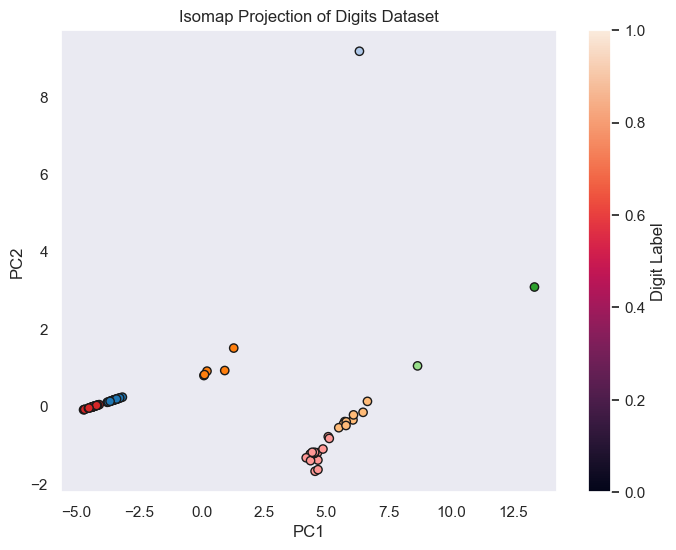

In [112]:
#ISOMAP
from sklearn.manifold import Isomap
# Apply Isomap to the data
iso = Isomap(n_components=2)  # Specify the number of components (dimensions)
iso_data = iso.fit_transform(data_scaled)

# Plot the transformed data
plt.figure(figsize=(8, 6))
plt.scatter(iso_data[:, 0], iso_data[:, 1], cmap='tab20', edgecolor='k', color = [plt.cm.tab20.colors[pred[i]] for i in range(len(pca_data))])
plt.colorbar(label='Digit Label')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Isomap Projection of Digits Dataset')
plt.show()

/var/folders/jl/05xr553n44v3_nqnn57t0f380000gn/T/ipykernel_14758/3220910716.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(mds_data[:, 0], mds_data[:, 1], cmap='tab20', edgecolor='k', color = [plt.cm.tab20.colors[pred[i]] for i in range(len(pca_data))])


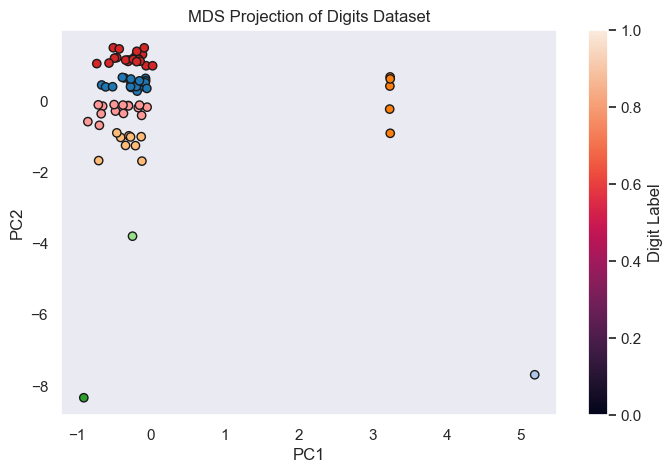

In [113]:
#MDS
from sklearn.manifold import MDS
# Apply MDS to the data
mds = MDS(n_components=2)  # Specify the number of components (dimensions)
mds_data = mds.fit_transform(data_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(mds_data[:, 0], mds_data[:, 1], cmap='tab20', edgecolor='k', color = [plt.cm.tab20.colors[pred[i]] for i in range(len(pca_data))])
plt.colorbar(label='Digit Label')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('MDS Projection of Digits Dataset')
plt.show()

La couleur des points varie progressivement, reflétant la continuité et la gradation des chiffres. Malgré cette distinction, un certain chevauchement existe, indiquant une similitude dans la représentation de certains chiffres, ce qui pourrait compliquer leur différenciation. De plus, la dispersion variable parmi les clusters révèle la diversité dans la représentation des chiffres, et les points isolés suggèrent la présence d'anomalies ou de variations inhabituelles au sein des données.

/var/folders/jl/05xr553n44v3_nqnn57t0f380000gn/T/ipykernel_14758/1321184982.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_data[:, 0], tsne_data[:, 1], cmap='tab20', edgecolor='k', color = [plt.cm.tab20.colors[pred[i]] for i in range(len(pca_data))])


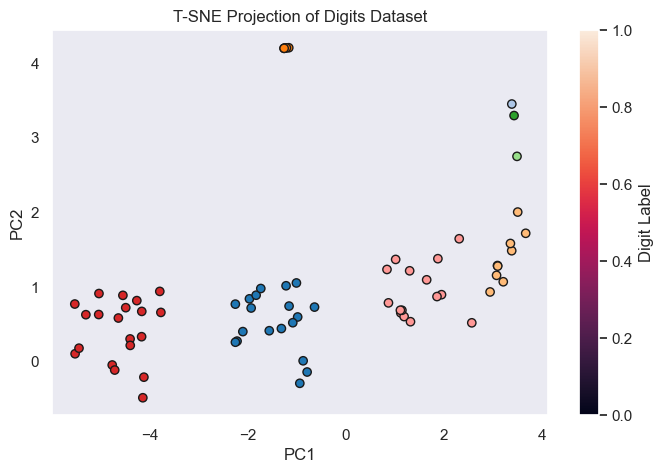

In [114]:
#TSNE
from sklearn.manifold import TSNE
# Apply t-SNE to the data
tsne = TSNE(n_components=2)  # Specify the number of components (dimensions)
tsne_data = tsne.fit_transform(data_scaled)

plt.figure(figsize=(8, 5))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1], cmap='tab20', edgecolor='k', color = [plt.cm.tab20.colors[pred[i]] for i in range(len(pca_data))])
plt.colorbar(label='Digit Label')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('T-SNE Projection of Digits Dataset')
plt.show()


Contrairement aux précédentes projections, celle-ci semble offrir une séparation plus claire entre les différents clusters, ce qui suggère que T-SNE est très efficace pour maintenir localement les similitudes et les distinctions entre les données. Les clusters sont distinctement séparés et ordonnés, ce qui témoigne de la puissance de T-SNE à dévoiler des structures cachées au sein de grandes ensembles de données complexes, comme les chiffres manuscrits.